In [2]:
from firedrake import *
import matplotlib.pyplot as plt
import numpy as np
from icepack import compute_surface
from icepack.constants import ice_density as rho_I, water_density as rho_W
from glac_adapt.adapt import mismip_bed_topography


firedrake:WARNING OMP_NUM_THREADS is not set or is set to a value greater than 1, we suggest setting OMP_NUM_THREADS=1 to improve performance


In [3]:
path = '/data/glac_adapt/test_cases/mismip/output_half'

def get_haf(h, s, Q):
    return interpolate(s - (1 - rho_I / rho_W) * h, Q)

def get_volumes(name, resolution, idx, mesh):
    fpath = f"{path}_{resolution}m/{name}.h5"

    with CheckpointFile(fpath, 'r') as afile:
        # mesh = afile.load_mesh("mesh_0")
        volumes = []
        for i in range(idx+1):
            h = afile.load_function(mesh, "thickness", idx=i)
            volumes.append(assemble(h*dx) / (1e9 * 917))
    
    return volumes

def load_fields(name, resolution, idx, volume=True):
    fpath = f"{path}_{resolution}m/{name}.h5"

    with CheckpointFile(fpath, 'r') as afile:
        mesh = afile.load_mesh("mesh_0")
        if volume:
            volumes = []
            for i in range(idx+1):
                h = afile.load_function(mesh, "thickness", idx=i)
                volumes.append(assemble(h*dx))
                u = afile.load_function(mesh, "velocity", idx=i)
        else:
            h = afile.load_function(mesh, "thickness", idx=idx)
            u = afile.load_function(mesh, "velocity", idx=idx)

    z_b = mismip_bed_topography(mesh, 80e3)
    s = compute_surface(thickness=h, bed=z_b)

    Q = FunctionSpace(mesh, "CG", 1)
    haf = get_haf(h, s, Q)

    if volume:
        volumes = np.array(volumes) / (1e9 * 917)
        return u, h, haf, volumes
    
    return u, h, haf

def plot_grounding_line(*hafs, colors=None, labels=None):
    n_hafs = len(hafs)
    
    levels = [-0.1, 0.01]
    fig, axes = plt.subplots(figsize=(13, 4))
    axes.set_xlim([440e3, 530e3])

    for i in range(n_hafs):
        im = tricontour(hafs[i], levels=levels, axes=axes, colors=colors[i], label="a")#labels[i])

    axes.legend(loc="best")

    return fig, axes

1
2
3
4
5
6
7
8
9
10


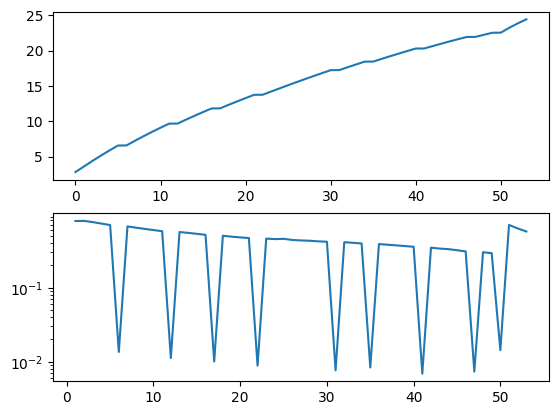

In [4]:
indices_ts2 = [5, 5, 4, 4, 2, 5, 3, 5, 5, 2]
indices_ts5 = [3, 4]
volume = []

with CheckpointFile('output_half_250m/steady-state-1.h5', 'r') as afile:
    mesh_250 = afile.load_mesh("mesh_0")

for i in range(1, 11):
    print(i)
    vols = get_volumes(f"steady-state-{i}", 250, indices_ts2[i-1], mesh_250)
    for vol in vols:
        volume.append(vol)

for i in range(11, 12):
    vols = get_volumes(f"steady-state-ts5-{i}", 250, indices_ts5[i-11], mesh_250)
    for vol in vols:
        volume.append(vol)

fig, axes = plt.subplots(2, 1)
xx = np.arange(len(volume))
axes[0].plot(xx, volume)
axes[1].semilogy(xx[1:], np.diff(volume))

# u, h, haf, vol_250_retreated = load_fields('steady-state-5', 250, 3, volume=True)

# plt.plot(np.arange(len(vol_250_retreated)), vol_250_retreated)

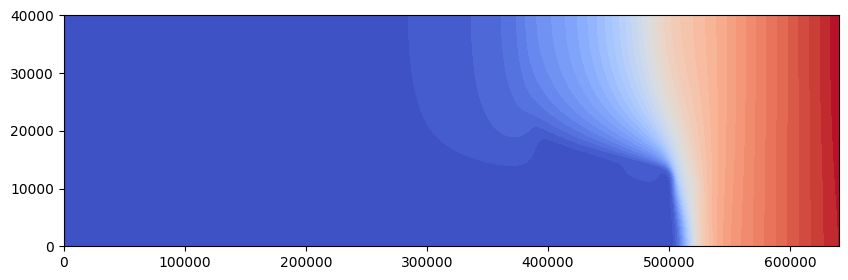

In [4]:
plot_kwargs = {"levels": 50, "cmap": "coolwarm"}
fig, axes = plt.subplots(figsize=(10, 3))
tricontourf(u, axes=axes, **plot_kwargs)

In [52]:
haf_arr = np.round(haf.dat.data, 2)
msh = haf.function_space().mesh()
x, y = msh.coordinates.dat.data[:, 0], msh.coordinates.dat.data[:, 1]

print(haf_arr.shape)
haf_arr_2d = haf_arr.reshape(np.unique(x).shape[0], np.unique(y).shape[0])
haf_arr_2d.shape

(412321,)


(2561, 161)

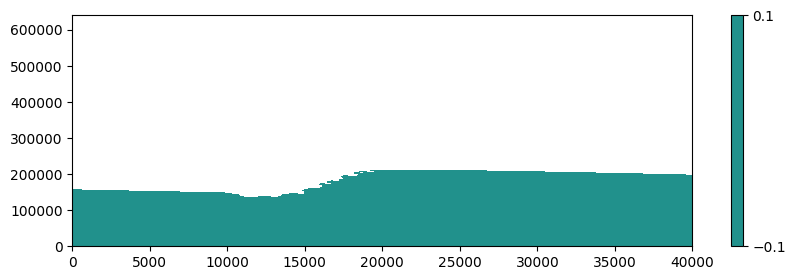

In [53]:
fig, axes = plt.subplots(figsize=(10, 3))
im = plt.contourf(np.unique(y), np.unique(x), haf_arr_2d, levels=[-0.1, 0.1])
fig.colorbar(im)

In [54]:
def get_contour(array, value):
    # Find the indices where the: value is present in the array
    indices = np.where(array == value)

    # Create an empty list to store the contour coordinates
    contour = []

    # Iterate through each index of the value in the array
    for i in range(len(indices[0])):
        # Check if the index is on the boundary of the array or not
        if indices[0][i] == 0 or indices[0][i] == array.shape[0]-1 or indices[1][i] == 0 or indices[1][i] == array.shape[1]-1:
            # If it is on the boundary, append it to the contour list
            contour.append([indices[0][i], indices[1][i]])

        # Check if the adjacent indices have a different value than the current value
        if indices[0][i] > 0 and array[indices[0][i]-1, indices[1][i]] != value:
            contour.append([indices[0][i], indices[1][i]])
        if indices[0][i] < array.shape[0]-1 and array[indices[0][i]+1, indices[1][i]] != value:
            contour.append([indices[0][i], indices[1][i]])
        if indices[1][i] > 0 and array[indices[0][i], indices[1][i]-1] != value:
            contour.append([indices[0][i], indices[1][i]])
        if indices[1][i] < array.shape[1]-1 and array[indices[0][i], indices[1][i]+1] != value:
            contour.append([indices[0][i], indices[1][i]])

    # Convert the contour list to a NumPy array and print it
    contour = np.array(contour)

    return contour


In [55]:
contour = get_contour(haf_arr_2d, 0.)

In [56]:
x_gl = np.unique(x)[contour[:, 0]]
y_gl = np.unique(y)[contour[:, 1]]

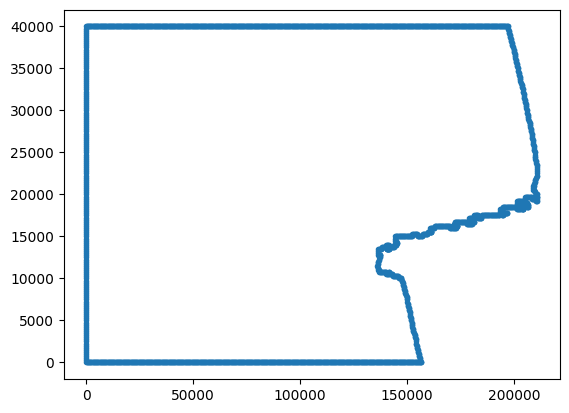

In [57]:
plt.plot(x_gl, y_gl, '.')

/home/ubuntu/software/firedrake-adapt/src/firedrake/firedrake/plot.py:207: UserWarning: The following kwargs were not used by contour: 'label'
  return method(triangulation, toreal(values, complex_component), *args, **kwargs)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(<Figure size 1300x400 with 1 Axes>, <AxesSubplot: >)

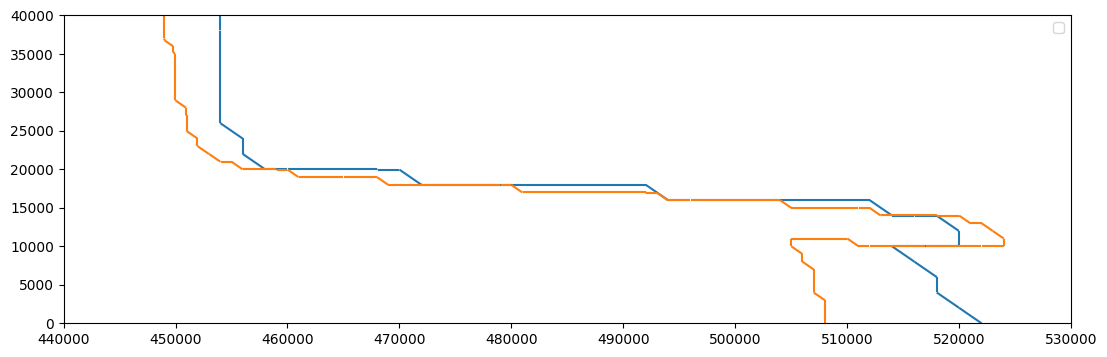

In [28]:
colors = ["C0", "C1"]
labels = ["2000m", "1000m"]

plot_grounding_line(haf_2000_steady, haf_1000_steady, colors=colors, labels=labels)

In [31]:
_, _, vol_2000_retreated = load_fields('retreated', 2000, 250, volume=True)
_, _, vol_1000_retreated = load_fields('retreated', 1000, 250, volume=True)
_, _, vol_2000_readvanced = load_fields('readvanced', 2000, 250, volume=True)
_, _, vol_1000_readvanced = load_fields('readvanced', 1000, 250, volume=True)

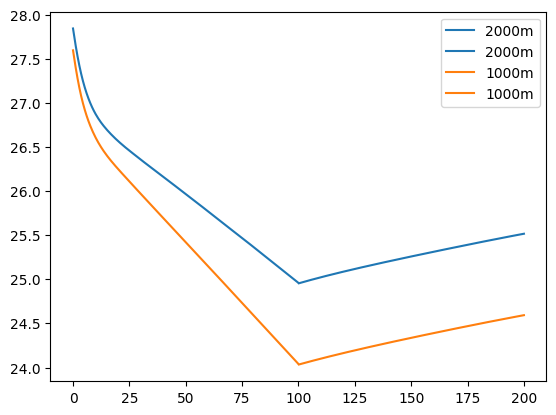

In [34]:
t = np.linspace(0, 200, 500)



plt.plot(t[:250], vol_2000_retreated, color="C0", label="2000m")
plt.plot(t[250:], vol_2000_readvanced, color="C0", label="2000m")
plt.plot(t[:250], vol_1000_retreated, color="C1", label="1000m")
plt.plot(t[250:], vol_1000_readvanced, color="C1", label="1000m")
plt.legend(loc="best")

NameError: name 'load_fields' is not defined